In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.models import mobilenet_v2
import os
import matplotlib.pyplot as plt
import numpy as np

# Define dataset path
data_dir = "realwaste-main\\RealWaste"  # Change this to your dataset location

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Reduce image size for faster processing
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes  # Class names

# Split into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders with optimized settings for CPU training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

# Load Pretrained MobileNetV2 model
model = mobilenet_v2(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(class_names))  # Adjust output layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1):  # Reduced to 1 epoch for speed
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        
        train_acc = correct / total * 100
        print(f"Epoch {epoch+1}: Loss: {total_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")
        
    print("Training complete!")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1)  # Only 1 epoch for speed

# Validation accuracy
def evaluate_model(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    print(f"Validation Accuracy: {correct / total * 100:.2f}%")

evaluate_model(model, val_loader)


Epoch 1: Loss: 1.2949, Accuracy: 56.12%
Training complete!
Validation Accuracy: 66.14%


In [31]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    """
    Visualize images with their predictions and actual labels
    
    Args:
        model: trained PyTorch model
        dataloader: DataLoader containing images to visualize
        class_names: list of class names
        num_images: number of images to visualize
    """
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 12))
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(1).cpu()
            
            for i in range(len(images)):
                if images_shown >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return
                
                # Get the image and denormalize it
                img = images[i].cpu().numpy().transpose(1, 2, 0)
                # Denormalize from [-1, 1] back to [0, 1]
                img = img * 0.5 + 0.5
                
                # Get the true and predicted labels
                true_label = class_names[labels[i]]
                pred_label = class_names[preds[i]]
                
                # Set color for the title based on correct/incorrect prediction
                color = 'green' if pred_label == true_label else 'red'
                
                # Plot the image
                plt.subplot(1, num_images, images_shown + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
                
                images_shown += 1
            
            if images_shown >= num_images:
                plt.tight_layout()
                plt.show()
                return

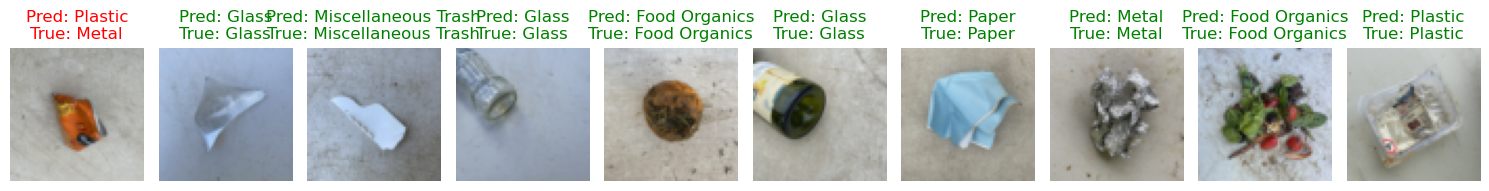

In [35]:
# Display predictions on some validation images
visualize_predictions(model, val_loader, class_names, num_images=10)

In [44]:
def approximate_multi_object_detection(model, image_path, class_names, window_sizes=[32, 48, 64], stride=16, conf_threshold=0.7):
    """
    Approximate multi-object detection using a classification model with smaller sliding windows
    
    Args:
        model: Trained classification model
        image_path: Path to the image
        class_names: List of class names
        window_sizes: List of window sizes to use (smaller windows for smaller objects)
        stride: Step size for sliding window
        conf_threshold: Confidence threshold for detection
    """
    from PIL import Image
    
    # Load image
    original_img = Image.open(image_path)
    original_width, original_height = original_img.size
    
    # Create transform for sliding windows
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize to model's expected input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    # Set model to evaluation mode
    model.eval()
    
    # Store detections
    detections = []
    
    # Use multiple window sizes
    for window_size in window_sizes:
        # Sliding window approach
        for y in range(0, original_height - window_size, stride):
            for x in range(0, original_width - window_size, stride):
                # Crop window
                window = original_img.crop((x, y, x + window_size, y + window_size))
                
                # Transform window
                window_tensor = transform(window).unsqueeze(0).to(device)
                
                # Get prediction
                with torch.no_grad():
                    outputs = model(window_tensor)
                    probs = torch.nn.functional.softmax(outputs, dim=1)
                    conf, pred_class = probs.max(1)
                
                # Skip background class if it exists
                class_idx = pred_class.item()
                if class_names[class_idx].lower() in ['background', 'none']:
                    continue
                
                # If confidence exceeds threshold, store detection
                if conf.item() > conf_threshold:
                    detections.append({
                        'box': [x, y, x + window_size, y + window_size],
                        'class': class_names[class_idx],
                        'confidence': conf.item(),
                        'size': window_size  # Store window size for visualization
                    })
    
    # Non-maximum suppression (simplified)
    final_detections = []
    detections.sort(key=lambda x: x['confidence'], reverse=True)
    
    while detections:
        best = detections.pop(0)
        final_detections.append(best)
        
        # Remove overlapping boxes with significant overlap
        detections = [det for det in detections if iou(best['box'], det['box']) < 0.3]
    
    # Display results
    plt.figure(figsize=(12, 12))
    img = np.array(original_img)
    plt.imshow(img)
    
    # Create a color map for different classes
    import matplotlib.colors as mcolors
    colors = list(mcolors.TABLEAU_COLORS.values())
    class_to_color = {cls: colors[i % len(colors)] for i, cls in enumerate(class_names)}
    
    for det in final_detections:
        x1, y1, x2, y2 = det['box']
        class_name = det['class']
        color = class_to_color.get(class_name, 'red')
        
        plt.gca().add_patch(
            plt.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                          fill=False, edgecolor=color, linewidth=2)
        )
        plt.text(x1, y1-5, f"{class_name}: {det['confidence']:.2f}", 
                color='white', backgroundcolor=color, fontsize=8)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return final_detections

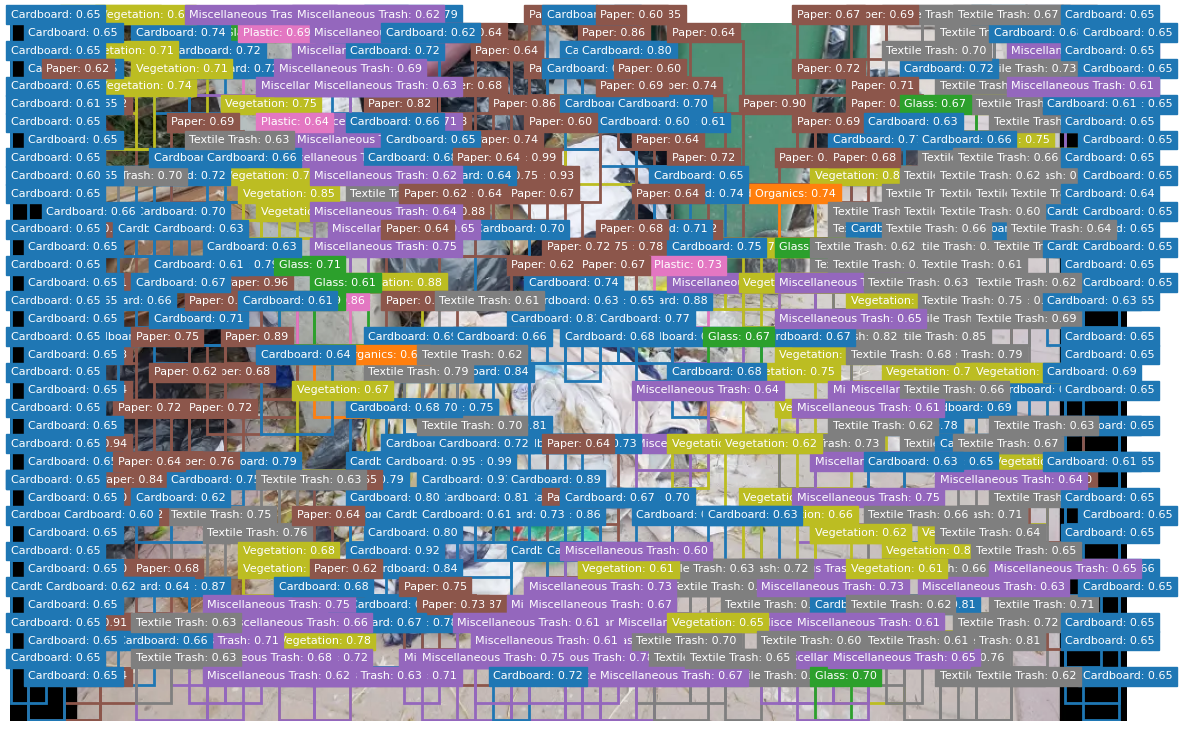

In [46]:
# Example usage with smaller windows
image_path = "C:\\Users\\amogh\\OneDrive\\Desktop\\rubbish-mound-overflowing-on-patio.webp"
detections = approximate_multi_object_detection(
    model, 
    image_path, 
    class_names, 
    window_sizes=[32, 48, 64],  # Use smaller windows
    stride=16,                  # Smaller stride for more detections
    conf_threshold=0.6          # Might need to adjust this based on results
)